In [1]:
# import libraries
import numpy as np
from matplotlib import pyplot as plt
import cv2
import math

%matplotlib inline

In [2]:
task1_2_type_result = [
    {"name" : "TESI00.BMP", "types" : {"A" : 2, "B" : 1}},
    {"name" : "TESI01.BMP", "types" : {"A" : 2, "B" : 1}},
    {"name" : "TESI12.BMP", "types" : {"A" : 2, "B" : 1}},
    {"name" : "TESI21.BMP", "types" : {"A" : 1, "B" : 1}},
    {"name" : "TESI31.BMP", "types" : {"A" : 1, "B" : 1}},
    {"name" : "Tesi33.BMP", "types" : {"A" : 2, "B" : 0}},
    {"name" : "TESI44.BMP", "types" : {"A" : 1, "B" : 0}},
    {"name" : "TESI47.BMP", "types" : {"A" : 1, "B" : 1}},
    {"name" : "TESI48.BMP", "types" : {"A" : 1, "B" : 1}},
    {"name" : "TESI49.BMP", "types" : {"A" : 0, "B" : 1}},
    {"name" : "TESI50.BMP", "types" : {"A" : 2, "B" : 1}},
    {"name" : "TESI51.BMP", "types" : {"A" : 2, "B" : 1}},
    {"name" : "TESI90.BMP", "types" : {"A" : 1, "B" : 1}},
    {"name" : "TESI92.BMP", "types" : {"A" : 2, "B" : 1}},
    {"name" : "TESI98.BMP", "types" : {"A" : 1, "B" : 1}},
]

In [3]:
def mn_moment(data, m, n):
    ''' Measure the moments of the image given the order m and n
    Inputs:
        data - the binary image as numpy matrix
        m - order of the vertical axis
        n - order of the horizontal axis
    Output:
        the moment
    '''
    if data is None or data.size == 0 or m is None or n is None:
        raise ValueError("Some required arguments are not correct")
    
    nrows, ncols = data.shape
    y_indices, x_indices = np.mgrid[:nrows, :ncols]
    return (data * x_indices ** m * y_indices ** n).sum()



def moments_cov(data, centroid):
    ''' Create the covariance matrix containing the moments up to second order
    Inputs:
        data - the binary image as numpy matrix
        centroid - the centroid coordinate as array or tuple
    Output:
        the covariance matrix containing the moments
    '''
    if data is None or data.size == 0 or centroid is None:
        raise ValueError("Some required arguments are not correct")
    
    m10 = mn_moment(data, 1, 0)
    m01 = mn_moment(data, 0, 1)
    m00 = mn_moment(data, 0, 0)
    u11 = (mn_moment(data, 1, 1) - centroid[0] * m01) / m00
    u20 = (mn_moment(data, 2, 0) - centroid[0] * m10) / m00
    u02 = (mn_moment(data, 0, 2) - centroid[1] * m01) / m00
    return np.array([[u20, u11], [u11, u02]])

In [4]:
def contact_points(data, major_equation, minor_equation):
    ''' Find the contact points between major and minor axes parallel lines and the contour of the object 
    and measure the width at the barycentre
    Inputs:
        data - the binary image as numpy matrix
        major_equation - list of type [a, b, c] representing the equation of the major axis
        major_equation - list of type [a, b, c] representing the equation of the minor axis
    Outputs:
        c1 - on major axis, negative maximum
        c2 - on major axis, positive maximum
        c3 - on minor axis, negative maximum
        c4 - on minor axis, positive maximum
        barycentre_width - the width at the barycentre (along the minor axis)
    '''
    if data is None or data.size == 0 or major_equation is None or minor_equation is None:
        raise ValueError("Some required arguments are not correct")
    
    # set maximum and minimum values to values easy to be changed in first iterations
    min_major_distance = math.inf
    max_major_distance = -math.inf
    min_minor_distance = math.inf
    max_minor_distance = -math.inf
    c1 = None
    c2 = None
    c3 = None
    c4 = None    
    min_barycentre_distance = math.inf
    max_barycentre_distance = -math.inf

    # for each point in the image, consider that coordinates could be misleading, moving in columns means changing the horizontal coordiante and vice vers
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            if data[y,x] == 255:
                # distance from the major axis as distance of a point to a line
                major_distance = (major_equation[1] * y + major_equation[0] * x + major_equation[2]) / math.sqrt((major_equation[0] ** 2) + (major_equation[1] ** 2))
                # distance from the minor axis as distance of a point to a line
                minor_distance = (minor_equation[1] * y + minor_equation[0] * x + minor_equation[2]) / math.sqrt((minor_equation[0] ** 2) + (minor_equation[1] ** 2))
                
                # update contact points looking at extremum horizontal and vertical values found so far
                if major_distance < min_major_distance:
                    min_major_distance = major_distance
                    c1 = [x, y]
                if major_distance > max_major_distance:
                    max_major_distance = major_distance 
                    c2 = [x, y]
                if minor_distance < min_minor_distance:
                    min_minor_distance = minor_distance
                    c3 = [x, y]
                if minor_distance > max_minor_distance:
                    max_minor_distance = minor_distance
                    c4 = [x, y]
                
                # if the point is close to the minor axes then it is considered in computing the width at the barycentre
                if abs(minor_distance) < 0.75:
                    # the distances are computed on both directions and summed as the final value
                    if major_distance < min_barycentre_distance:
                        min_barycentre_distance = major_distance
                    if major_distance > max_barycentre_distance:
                        max_barycentre_distance = major_distance
    
    return c1, c2, c3, c4, abs(min_barycentre_distance) + abs(max_barycentre_distance)

In [5]:
def line_intersection(p1, p2, m1, m2):
    ''' Intersect 2 lines given 2 points and the associated slopes 
    Inputs:
        p1 - first point of first line [x,y]
        p2 - fist point of second line [x,y]
        m1 - slope of first line
        m2 - slope of second line
    Outputs:
        res - the intersection of the two lines if possible, array on np.nan otherwise     
    '''
    if p1 is None or p2 is None or m1 is None or m2 is None:
        raise ValueError("Some required arguments are not correct")

    # prepare the matrices to solve the linear system of equations to find the intersection if there is
    a = np.array([[-m1, 1],
                  [-m2, 1]])
    b = np.array([p1[1] - m1 * p1[0], p2[1] - m2 * p2[0]])
    try:
        res = np.linalg.solve(a, b)
    except:
        res = np.array([np.nan, np.nan])

    return res

In [6]:
minimum_distance_between_barycentres = 5
def task1c_rod_filter(rod_centroid, hole_centroid):
    '''
    Inputs:
        rod_centroid - rod position as numpy array
        hole_centroid - hole position as numpy array
    Outputs:
        True if the rod must be filtered and not considered
    '''
    if rod_centroid is None or rod_centroid.size == 0 or hole_centroid is None or hole_centroid.size == 0:
        raise ValueError("Some required arguments are not correct")

    distance = math.sqrt((hole_centroid[0] - rod_centroid[0])** 2 + (hole_centroid[1] - rod_centroid[1])** 2)
    if distance < minimum_distance_between_barycentres:
        return True
    return False

area_threshold = 11
def task2c_rod_filter(rod_info):
    '''
    Inputs:
        rod_info - a numpy array containing information on the opencv connectedComponentsWithStats function
    Outputs:
        True if the rod must be filtered and not considered
    '''
    if rod_info is None or rod_info.size == 0:
        raise ValueError("Some required arguments are not correct")

    if rod_info[4] < area_threshold:
        return True
    return False


def preprocessing(image, allow_print=True):
    ''' Otsu - close - open - dilate 
    Inputs:
        image - the image to preprocess as numpy matrix
        allow_print - True print preprocessing results
    Outputs:
        the preprocessed image
    '''
    if image is None or image.size == 0 or allow_print is None:
        raise ValueError("Some required arguments are not correct")

    if allow_print:
        plt.imshow(image)
        plt.title("Original")
        plt.show()

    # segmentation
    task2c_ret_otsu, task2c_th_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # close it
    task2c_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2,2))

    closed = cv2.morphologyEx(task2c_th_otsu, cv2.MORPH_CLOSE, task2c_kernel)
    if allow_print:
        plt.title("Closing")
        plt.imshow(closed)
        plt.show()

    # then open it
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, task2c_kernel)
    if allow_print:
        plt.title("Opening")
        plt.imshow(opened)
        plt.show()

    # and finally dilate it
    task2c_dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    dilated = cv2.dilate(opened, task2c_dilation_kernel, iterations = 1)
    if allow_print:
        plt.title("Dilate")
        plt.imshow(dilated)
        plt.show()
    
    return dilated

In [7]:
def main(image): 
    ''' The core of the project, contains the main algorithm to solve the problem 
    Inputs:
        image - the image to be processed as numpy matrix
    Outputs:
        rods - list of dictionaries containing all the results for each rod
    '''
    if image is None or image.size == 0:
        raise ValueError("Some required arguments are not correct")

    # Preprocess image
    image = preprocessing(image)

    # find rods as connected components using a specific connectivity value  
    rod_connectivity = 4

    # rod_num, is the number of rods
    # rod_labelled_image, is the original image where each pixel is sunstituted by the correct label
    # rod_info, contains some informations about the blobs, as the area
    # rod_centroids, contains the centroid of each blob
    rod_num, rod_labelled_image, rod_info, rod_centroids = cv2.connectedComponentsWithStats(image, rod_connectivity, cv2.CV_32S)
    labels = np.unique(rod_labelled_image)
    print("Labels found {}".format(rod_num))

    # consider as a background the blob with maximum area
    background_label = np.argmax(rod_info[:,4])

    # rods is a list of dictionaries containing the requested information for each rod
    rods = []

    # for each label, so rod
    for label in labels:
        # exclude background and rods with area below threshold
        if label != background_label and not task2c_rod_filter(rod_info[label]):
            
            # create a binary image from the original one considering the labelled image: only the current rod will have the foreground value
            rod_image = image.copy()
            rod_image[rod_labelled_image == label] = 255
            rod_image[rod_labelled_image != label] = 0

            # create a binary image from the binary of the rod as its negative: only the holes of the current rod will have the foreground value
            hole_image = rod_image + 255
            hole_image[hole_image != 255] = 0        

            # find holes as connected components
            hole_connectivity = 4
            hole_num, hole_labelled_image, hole_info, hole_centroids = cv2.connectedComponentsWithStats(hole_image, hole_connectivity, cv2.CV_32S)

            # exclude background and rod
            ignore_index = (np.argsort(hole_info[:,4])[::-1])[0:2]
  
            rod = {"index":label}
            rods.append(rod)

            rods[-1]["area"] = rod_info[label][4]
            rods[-1]["centroid"] = rod_centroids[label].round().astype(np.int)
            
            rods[-1]["holes"] = []
            
            counter = 0
            # iterating the holes if two are found then the rod is labelled, if more than 2 are found an error is raised
            for index, area in enumerate(hole_info[:,4]):
                if not (index in ignore_index) :
                    rods[-1]["holes"].append({"diameter":round(math.sqrt((area / math.pi)) * 2, 2), "centre":hole_centroids[index].round().astype(np.int)})
                    if counter == 0:
                        rods[-1]["type"] = "A"
                        counter += 1                        
                    elif counter == 1:
                        rods[-1]["type"] = "B"
                        counter += 1
                    elif counter > 1:
                        raise Exception("Error too many holes in a single rod index {}".format(index))

            # ignore rods without holes
            if rods[-1]["holes"] == []:
                del rods[-1]
                continue
                
            # ignore washers
            if rods[-1]["type"] == "A" and task1c_rod_filter(rod_centroids[label], rods[-1]["holes"][0]["centre"]):
                del rods[-1]["holes"]
                del rods[-1]
                continue

            # use covariance matrix to find major and minor axes
            cov = moments_cov(rod_image, rods[-1]["centroid"])
            eigenvalues, eigenvectors = np.linalg.eig(cov)
            sort_indices = np.argsort(eigenvalues)[::-1]
            major_axes = eigenvectors[:, sort_indices[0]]
            minor_axes = eigenvectors[:, sort_indices[1]]

            # find alpha and beta to compute the major and minor axes equations
            alpha = major_axes[1]
            beta = major_axes[0]

            # find theta
            theta = -0.5 * math.atan2((2 * cov[0,1]), (cov[0,0] - cov[1,1]))
            rods[-1]["angle"] = round(math.degrees(theta), 2)

            # store major and minor equations
            major_equation = [alpha, -beta, beta * rods[-1]["centroid"][1] - alpha * rods[-1]["centroid"][0]]
            minor_equation = [beta, alpha, -beta * rods[-1]["centroid"][0] - alpha * rods[-1]["centroid"][1]]

            # find contact points and width at the barycentre
            c1, c2, c3, c4, barycentre_width = contact_points(rod_image, major_equation, minor_equation)
            rods[-1]["baricentre_width"] = round(barycentre_width, 2)

            # compute MER vertices
            v1 = line_intersection(c1, c3, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])
            v2 = line_intersection(c1, c4, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])
            v3 = line_intersection(c2, c3, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])
            v4 = line_intersection(c2, c4, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])

            # measure length and width
            rods[-1]["length"] = round(math.sqrt(((v1[0] - v2[0])**2) + ((v1[1] - v2[1])**2)), 2)
            rods[-1]["width"] = round(math.sqrt(((v1[0] - v3[0])**2) + ((v1[1] - v3[1])**2)), 2)

            # Draw        
            # MER
            plt.plot([v1[0], v2[0]], [v1[1], v2[1]], color="#0000ff") #blue
            plt.plot([v2[0], v4[0]], [v2[1], v4[1]], color="#ff0000") #red
            plt.plot([v3[0], v1[0]], [v3[1], v1[1]], color="#c932c1") #purple
            plt.plot([v4[0], v3[0]], [v4[1], v3[1]], color="#00ff00") #green

            # Major and minor axes
            scale = 20
            plt.plot([major_axes[0] * -scale * 2 + rods[-1]["centroid"][0], major_axes[0] * scale * 2 + rods[-1]["centroid"][0]],
                     [major_axes[1] * -scale * 2 + rods[-1]["centroid"][1], major_axes[1] * scale * 2 + rods[-1]["centroid"][1]], color='black')
            plt.plot([minor_axes[0] * -scale + rods[-1]["centroid"][0], minor_axes[0] * scale + rods[-1]["centroid"][0]],
                     [minor_axes[1] * -scale + rods[-1]["centroid"][1], minor_axes[1] * scale + rods[-1]["centroid"][1]], color='black')
            plt.imshow(rod_image)
            plt.show()
            print(rods[-1])
    return rods

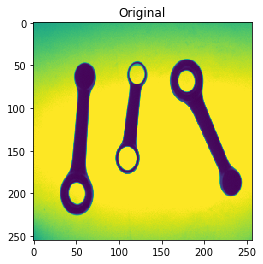

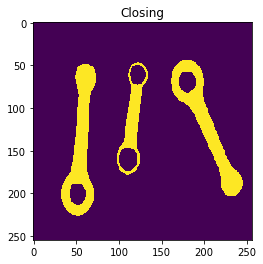

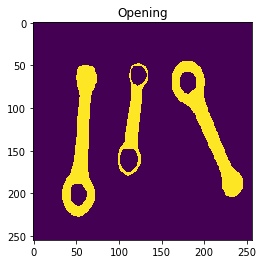

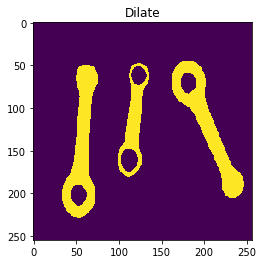

Labels found 4


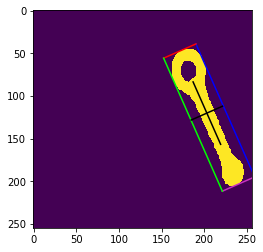

{'index': 1, 'area': 3546, 'centroid': array([203, 120]), 'holes': [{'diameter': 20.71, 'centre': array([181,  71])}], 'type': 'A', 'angle': -66.19, 'baricentre_width': 16.15, 'length': 170.5, 'width': 41.41}


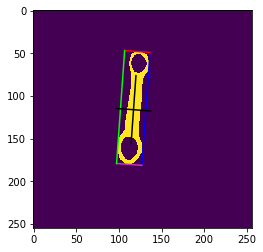

{'index': 2, 'area': 1766, 'centroid': array([117, 116]), 'holes': [{'diameter': 19.41, 'centre': array([123,  62])}, {'diameter': 22.88, 'centre': array([112, 161])}], 'type': 'B', 'angle': 85.92, 'baricentre_width': 15.1, 'length': 132.73, 'width': 29.79}


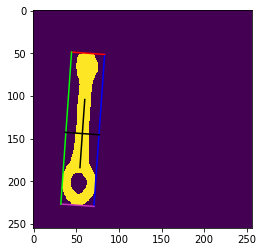

{'index': 3, 'area': 3552, 'centroid': array([ 57, 144]), 'holes': [{'diameter': 20.78, 'centre': array([ 53, 202])}], 'type': 'A', 'angle': 85.96, 'baricentre_width': 16.03, 'length': 178.61, 'width': 38.89}


[{'index': 1,
  'area': 3546,
  'centroid': array([203, 120]),
  'holes': [{'diameter': 20.71, 'centre': array([181,  71])}],
  'type': 'A',
  'angle': -66.19,
  'baricentre_width': 16.15,
  'length': 170.5,
  'width': 41.41},
 {'index': 2,
  'area': 1766,
  'centroid': array([117, 116]),
  'holes': [{'diameter': 19.41, 'centre': array([123,  62])},
   {'diameter': 22.88, 'centre': array([112, 161])}],
  'type': 'B',
  'angle': 85.92,
  'baricentre_width': 15.1,
  'length': 132.73,
  'width': 29.79},
 {'index': 3,
  'area': 3552,
  'centroid': array([ 57, 144]),
  'holes': [{'diameter': 20.78, 'centre': array([ 53, 202])}],
  'type': 'A',
  'angle': 85.96,
  'baricentre_width': 16.03,
  'length': 178.61,
  'width': 38.89}]

In [8]:
index = 0
image = cv2.imread("../data/" + task1_2_type_result[index]["name"], cv2.IMREAD_GRAYSCALE)
main(image)